In [79]:
%matplotlib inline

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Designing an Architecture for Recognizing UVA Historical Landmarks
![UVA Grounds](https://sworld.co.uk/img/img/131/photoAlbum/5284/originals/0.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praises for its unique Jeffersonian architecture.

We attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. 

# Load Packages

In [61]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

import torch
import torch.nn as nn

# Random Seed for Reproduction

In [62]:
from torch import manual_seed as torch_manual_seed
import random
import numpy as np

from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save time, a subset of the data has been resized and compressed to only 379Mb and stored in a Firebase server.

In [63]:
# Download dataset from FirebaseStorage
# !curl -L "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7" -o "dataset.zip"


In [64]:
# Extract content
# !unzip -qo "dataset.zip"

In [65]:
from sklearn.datasets import load_files

data_dir = "dataset/"
BATCH_SIZE = 64;
img_height = 150;
img_width = 150;


In [66]:
from torch.utils.data import DataLoader, random_split
from torch import Generator
from torchvision.transforms import ToTensor, Resize, Compose
from torchvision.datasets import ImageFolder


TEST_RATIO = 0.2

# Download and load the training data
# Define transforms
transform = Compose([
    Resize([img_height, img_width]),
    ToTensor()
])

dataset_all = ImageFolder(
    data_dir,
    transform=ToTensor(),
)

size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all)={size_all}')


size_test = int(size_all * TEST_RATIO)
size_train = size_all - size_test

dataset_train, dataset_test = random_split(dataset_all, [size_train, size_test], generator=Generator().manual_seed(SEED))
print(f'After splitting the full dataset into train and test: len(dataset_train)={len(dataset_train)}. len(dataset_test)={len(dataset_test)}')

# NOTE that you must not use the test dataset for model selection


Before splitting the full dataset into train and test: len(dataset_all)=14286
After splitting the full dataset into train and test: len(dataset_train)=11429. len(dataset_test)=2857


In [67]:
#Validation set
size_alltrain = len(dataset_train)
print(f'Before splitting the train dataset into train and val: len(dataset_train)={size_alltrain}')

size_val = int(size_alltrain * TEST_RATIO)
size_train2 = size_alltrain - size_val

dataset_train, dataset_val = random_split(dataset_train, [size_train2, size_val], generator=Generator().manual_seed(SEED))
print(f'After splitting the train dataset into train and val: len(dataset_train)={len(dataset_train)}, len(dataset_val)={len(dataset_val)}')

Before splitting the train dataset into train and val: len(dataset_train)=11429
After splitting the train dataset into train and val: len(dataset_train)=9144, len(dataset_val)=2285


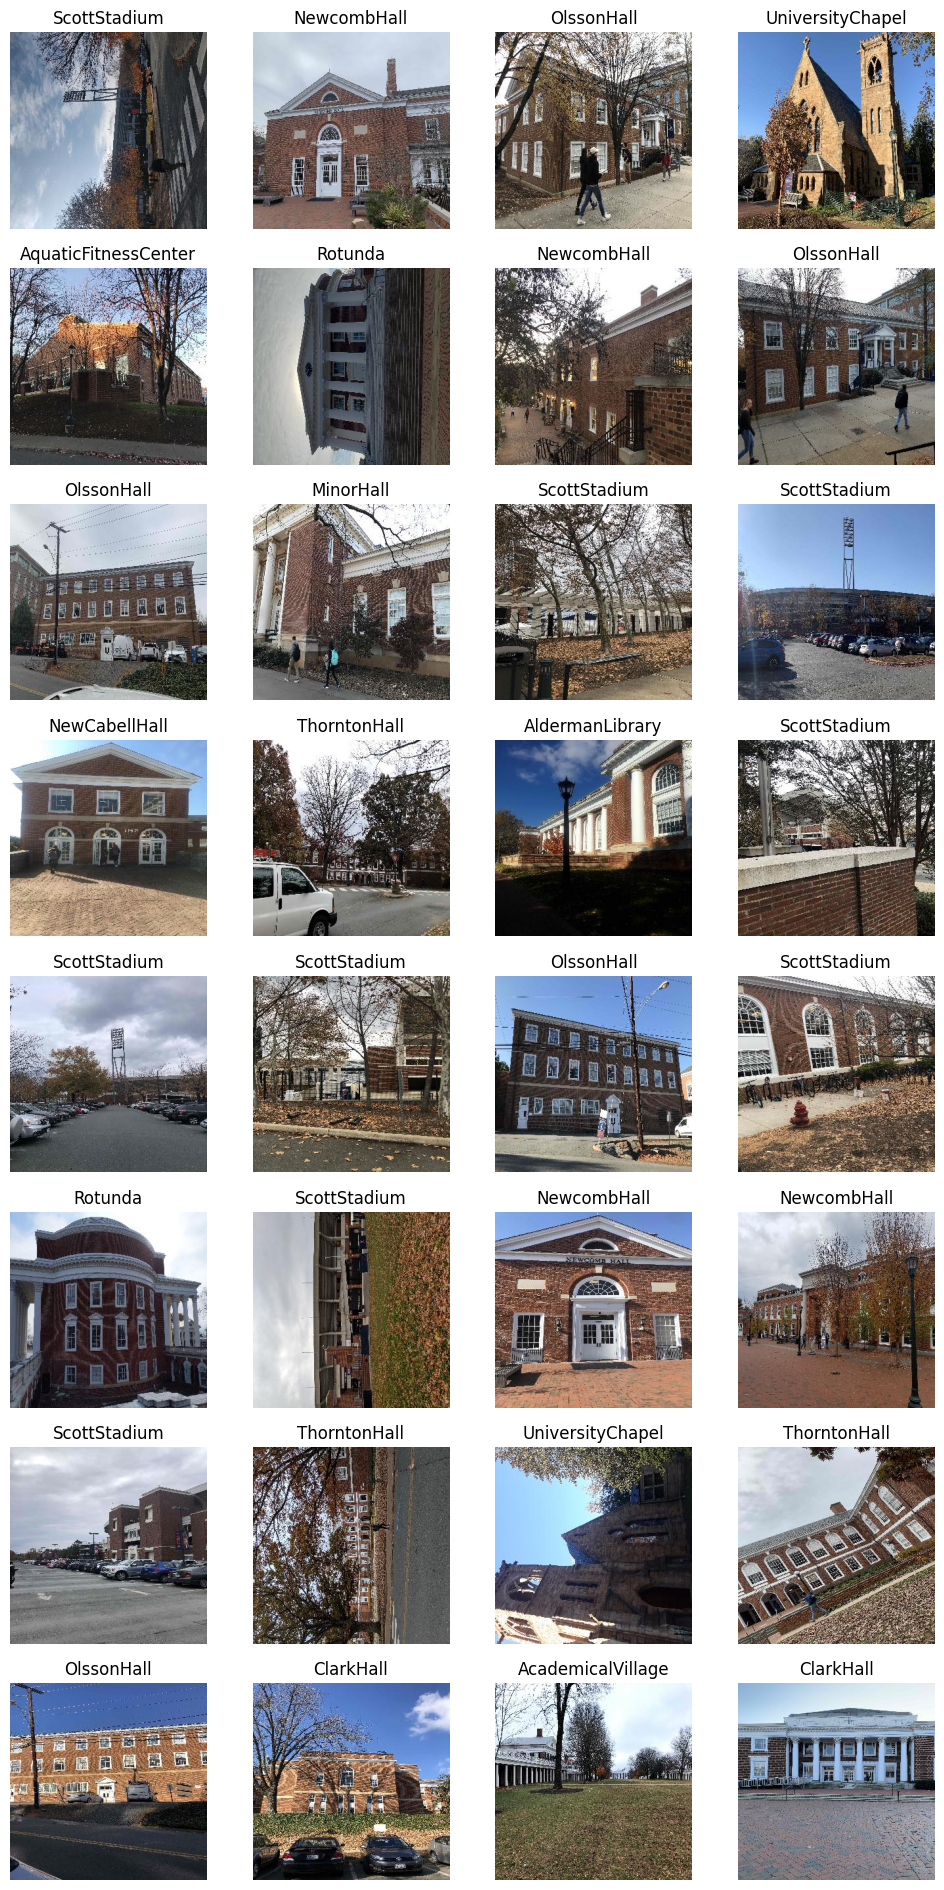

In [68]:
from torchvision.transforms.functional import to_pil_image


# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
  'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall', 'NewCabellHall',
  'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall', 'Rotunda', 'ScottStadium',
  'ThorntonHall', 'UniversityChapel']
num_classes = len(class_names)

# Rows and columns are set to fit one training batch (32)

n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)
plt.show()

# Building a classifier for UVA Landmark Dataset

In [69]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models import vgg16
from torchvision.models import resnet18
from torchvision import models
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time

In [12]:
device = torch.device("cuda")

In [13]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.optim as optim
from tqdm import tqdm

In [46]:
# Create DataLoader
# Initialize train, validation and test dataloaders
trainDataLoader = DataLoader(dataset_train, shuffle=True, batch_size=BATCH_SIZE, num_workers=8)
valDataLoader = DataLoader(dataset_val, batch_size=BATCH_SIZE, num_workers=8)
testDataLoader = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=8)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

## Module 1 : LeNet

In [15]:
# from torch.nn import Module

# class LeNet(Module):
#     def __init__(self, numChannels, classes):
#         super(LeNet, self).__init__()

#         #Initialize first set of CONV: RELU > POOL layers
#         self.conv1 = Conv2d(in_channels=3, out_channels=32,kernel_size=(5, 5))
#         self.relu1 = ReLU()
#         self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

#         #Initialize second set of CONV: RELU > POOL layers
#         self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))
#         self.relu2 = ReLU()
#         self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


#         #Initialize set of Fully Connected layers
#         self.fc1 = Linear(in_features=64*72*72, out_features=200)
#         self.relu3 = ReLU()

#         #Initialize Softmax classifier
#         self.fc2 = Linear(in_features=200, out_features=classes)
#         self.logSoftmax = LogSoftmax(dim=1)

#     def forward(self, X):
#         #print(X.shape)

#         #pass the input through first CONV layer
#         X = self.conv1(X)
#         X = self.relu1(X)
#         X = self.maxpool1(X)
#         #print("Conv1 output shape:", X.shape)

#         #pass through second CONV layer
#         X = self.conv2(X)
#         X = self.relu2(X)
#         X = self.maxpool2(X)
#         #print("Conv2 output shape:", X.shape)

#         #flatten the output and pass through FC
#         #X = flatten(X, 1) #flatten the output
#         X = X.view(X.size(0), -1)
#         X = self.fc1(X)
#         X = self.relu3(X)

#         #pass output to softmax classifier
#         X = self.fc2(X)
#         X = self.logSoftmax(X)

#         #print(X.shape)

#         #return the output predictions
#         return X

In [70]:
from torch.nn import Module

class LeNet(Module):
    def __init__(self, numChannels, classes):
        super(LeNet, self).__init__()

        #Initialize first set of CONV: RELU > POOL layers
        self.conv1 = Conv2d(in_channels=3, out_channels=32,kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        #Initialize second set of CONV: RELU > POOL layers
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))


        #Initialize set of Fully Connected layers
        self.fc1 = Linear(in_features=64*72*72, out_features=200)
        self.relu3 = ReLU()

        #Initialize Softmax classifier
        self.fc2 = Linear(in_features=200, out_features=classes)
        #self.logSoftmax = LogSoftmax(dim=1)
        
    def forward(self, X):
        #print(X.shape)

        #pass the input through first CONV layer
        X = self.conv1(X)
        X = self.relu1(X)
        X = self.maxpool1(X)
        #print("Conv1 output shape:", X.shape)

        #pass through second CONV layer
        X = self.conv2(X)
        X = self.relu2(X)
        X = self.maxpool2(X)
        #print("Conv2 output shape:", X.shape)

        #flatten the output and pass through FC
        #X = flatten(X, 1) #flatten the output
        X = X.view(X.size(0), -1)
        X = self.fc1(X)
        X = self.relu3(X)

        #pass output to softmax classifier
        X = self.fc2(X)
        #X = self.logSoftmax(X)

        #print(X.shape)

        #return the output predictions
        return X

In [71]:
def train_loop(dataloader, model, loss_fn, optimizer, calculating_accuracy=True):
    model.train()
    size = len(dataloader.dataset)
    losses_train = []
    steps = []
    if calculating_accuracy:
        accuracies_epoch = []
    for batch, (X, y) in enumerate(dataloader):
        # Move data from the CPU to the GPU
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss (forward pass)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation (backward pass)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        current = batch * len(X)

        loss = loss.item()
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses_train.append(loss)
        steps.append(current)
        # Compute accuracy without affecting the gradients

        if calculating_accuracy:
            with torch.no_grad():
                accuracy_batch = (pred.argmax(1) == y).type(
                    torch.float).sum().item()/len(y)
            accuracies_epoch.append(accuracy_batch)
    if not calculating_accuracy:
        return losses_train, [], steps
    return losses_train, accuracies_epoch, steps

In [73]:
import torch


@torch.no_grad()
def test_loop(dataloader, model, loss_fn, method="Test", calculating_accuracy=True):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    if calculating_accuracy:
        correct = 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        if calculating_accuracy:
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    if not calculating_accuracy:
        print(f"{method} Avg loss: {test_loss:>8f} \n")
        return -1, test_loss
    correct /= size
    print(f"{method} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [74]:
import torch
from torch import nn

model = LeNet(numChannels=3, classes=num_classes).to(device)  # Assuming NUM_CLASSES is defined elsewhere
learning_rate = 0.01
NUM_EPOCHS = 30

dataloader_train = trainDataLoader
dataloader_valid = valDataLoader


def train(model, num_epochs, loss_function, optimizer, dataloader_train, dataloader_valid, calculating_accuracy=True):
    losses_train_all_epochs = []
    accuracies_train_all_epochs = []
    steps_all_epochs = []
    accuracies_val_all_epochs = []
    losses_val_all_epochs = []

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        losses_train, accuracies_epoch, steps = train_loop(
            dataloader_train, model, loss_function, optimizer, calculating_accuracy=calculating_accuracy)
        losses_train_all_epochs.append(losses_train)
        accuracies_train_all_epochs.append(accuracies_epoch)
        steps_all_epochs.append(steps)

        accuracy_val, loss_val = test_loop(
            dataloader_valid, model, loss_function, method="Valid", calculating_accuracy=calculating_accuracy)
        accuracies_val_all_epochs.append(accuracy_val)
        losses_val_all_epochs.append(loss_val)
    print("Done!")
    return accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs


loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
accuracies_train_all_epochs, accuracies_val_all_epochs, losses_train_all_epochs, losses_val_all_epochs = train(
    model, NUM_EPOCHS, loss_function, optimizer, dataloader_train, dataloader_valid)

Epoch 1
-------------------------------
loss: 2.887319  [    0/ 9144]
loss: 2.730911  [ 6400/ 9144]
Valid Error: 
 Accuracy: 16.4%, Avg loss: 2.658744 

Epoch 2
-------------------------------
loss: 2.708755  [    0/ 9144]
loss: 2.563452  [ 6400/ 9144]
Valid Error: 
 Accuracy: 25.9%, Avg loss: 2.420626 

Epoch 3
-------------------------------
loss: 2.579735  [    0/ 9144]
loss: 2.458583  [ 6400/ 9144]
Valid Error: 
 Accuracy: 28.8%, Avg loss: 2.305910 

Epoch 4
-------------------------------
loss: 2.168067  [    0/ 9144]
loss: 2.195123  [ 6400/ 9144]
Valid Error: 
 Accuracy: 31.3%, Avg loss: 2.264157 

Epoch 5
-------------------------------
loss: 2.153293  [    0/ 9144]
loss: 2.131932  [ 6400/ 9144]
Valid Error: 
 Accuracy: 37.9%, Avg loss: 2.034423 

Epoch 6
-------------------------------
loss: 1.757860  [    0/ 9144]
loss: 2.056833  [ 6400/ 9144]
Valid Error: 
 Accuracy: 37.0%, Avg loss: 2.109891 

Epoch 7
-------------------------------
loss: 1.653791  [    0/ 9144]
loss: 1.7523

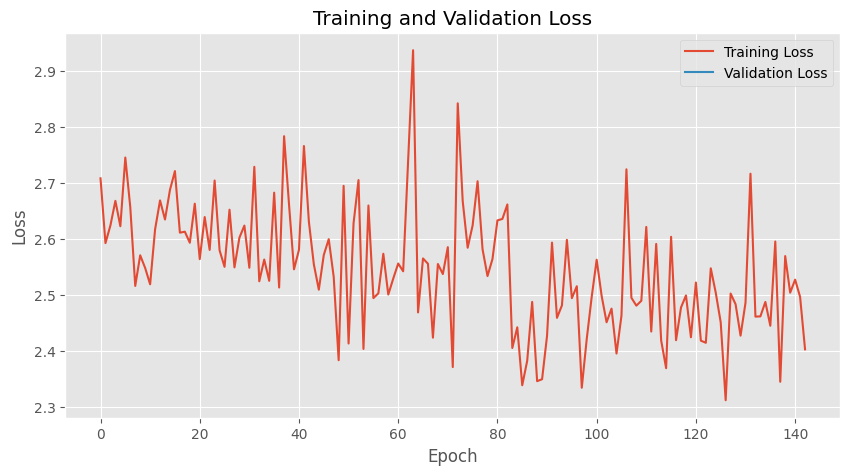

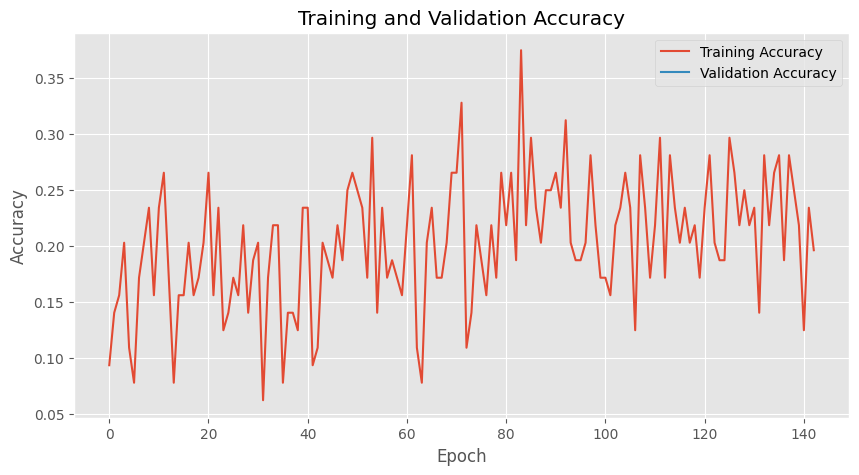

In [85]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(losses_train_all_epochs[1], label='Training Loss')
plt.plot(losses_val_all_epochs[1], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(accuracies_train_all_epochs[1], label='Training Accuracy')
plt.plot(accuracies_val_all_epochs[1], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [77]:
# Testing 
loss_function = nn.CrossEntropyLoss()
correct, test_loss = test_loop(testDataLoader, model, loss_fn=loss_function, method="Test", calculating_accuracy=True)

Test Error: 
 Accuracy: 61.4%, Avg loss: 2.104579 



In [83]:
#losses_train_all_epochs[1]

**Comment: 
I am getting test accuracy of upto 61% with LeNet model.**

## Old code for training and testing of LeNet

In [50]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

NUM_EPOCHS = 10

# Initialize the model
model = LeNet(numChannels=3, classes=num_classes)  # Assuming NUM_CLASSES is defined elsewhere
model.to(device, non_blocking=True)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Function to calculate accuracy
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):  # Assuming NUM_EPOCHS is defined elsewhere
    # Train the model
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in trainDataLoader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    # Calculate training accuracy and loss
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss / len(trainDataLoader))
    train_accuracies.append(train_accuracy)

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valDataLoader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # Calculate validation accuracy and loss
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss / len(valDataLoader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 14.9114, Train Acc: 0.1194, Val Loss: 2.6935, Val Acc: 0.1637
Epoch [2/10], Train Loss: 2.6758, Train Acc: 0.1516, Val Loss: 2.7010, Val Acc: 0.1427
Epoch [3/10], Train Loss: 2.5645, Train Acc: 0.1943, Val Loss: 2.5905, Val Acc: 0.1969
Epoch [4/10], Train Loss: 2.2596, Train Acc: 0.3016, Val Loss: 2.6305, Val Acc: 0.1930
Epoch [5/10], Train Loss: 1.6858, Train Acc: 0.4896, Val Loss: 3.1172, Val Acc: 0.1812
Epoch [6/10], Train Loss: 1.0571, Train Acc: 0.6786, Val Loss: 3.7763, Val Acc: 0.1602
Epoch [7/10], Train Loss: 0.7282, Train Acc: 0.7808, Val Loss: 6.0438, Val Acc: 0.1663
Epoch [8/10], Train Loss: 0.4040, Train Acc: 0.8825, Val Loss: 6.1055, Val Acc: 0.1505
Epoch [9/10], Train Loss: 0.2897, Train Acc: 0.9191, Val Loss: 8.5520, Val Acc: 0.1676
Epoch [10/10], Train Loss: 0.2302, Train Acc: 0.9389, Val Loss: 10.2038, Val Acc: 0.1593


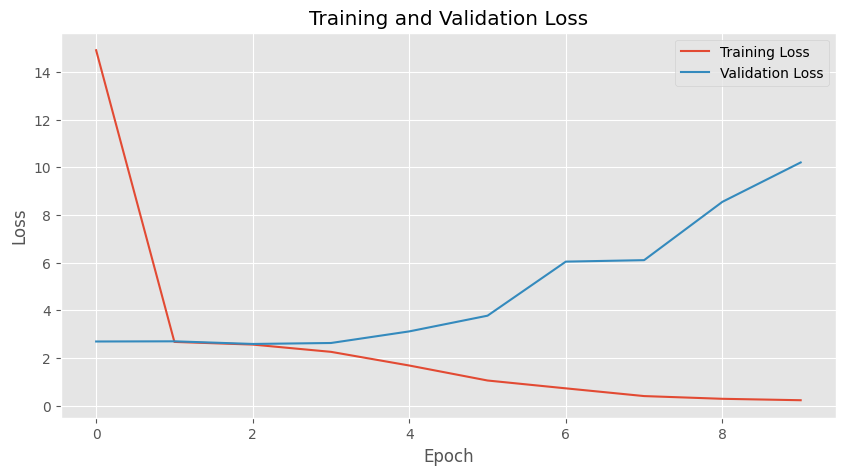

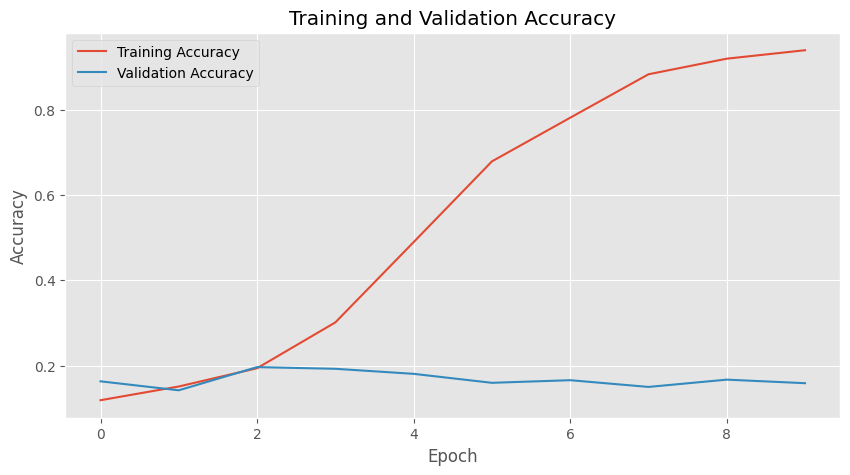

In [52]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
# Validate the model
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in testDataLoader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Calculate validation accuracy and loss
test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.1635


**Comment:   
I created LeNet model, and can see the test accuracy of upto 16%. 
I couldn't determine why validtion accuracy is not improved with each epoch.**

# Model 2

In [54]:
# Define VGG model with transfer learning
class MyVGG(nn.Module):
    def __init__(self, num_classes):
        super(MyVGG, self).__init__()
        self.vgg = vgg16(pretrained=True)
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.vgg.classifier[-1] = nn.Linear(self.vgg.classifier[-1].in_features, num_classes)

    def forward(self, x):
        return self.vgg(x)

# Define the model, loss function, and optimizer
model = MyVGG(num_classes=num_classes)
model.to(device, non_blocking=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, labels) in enumerate(trainDataLoader, 0):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    train_loss = running_loss / len(trainDataLoader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valDataLoader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
    val_loss /= len(valDataLoader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 1.7332, Val Loss: 1.2083, Train Acc: 0.4887, Val Acc: 0.6530
Epoch [2/10], Train Loss: 1.4104, Val Loss: 1.0838, Train Acc: 0.5875, Val Acc: 0.6867
Epoch [3/10], Train Loss: 1.3142, Val Loss: 1.0245, Train Acc: 0.6171, Val Acc: 0.7182
Epoch [4/10], Train Loss: 1.2555, Val Loss: 1.0004, Train Acc: 0.6323, Val Acc: 0.7072
Epoch [5/10], Train Loss: 1.2054, Val Loss: 0.9522, Train Acc: 0.6497, Val Acc: 0.7300
Epoch [6/10], Train Loss: 1.1922, Val Loss: 0.9564, Train Acc: 0.6521, Val Acc: 0.7326
Epoch [7/10], Train Loss: 1.1742, Val Loss: 0.9100, Train Acc: 0.6549, Val Acc: 0.7444
Epoch [8/10], Train Loss: 1.1320, Val Loss: 0.8584, Train Acc: 0.6663, Val Acc: 0.7637
Epoch [9/10], Train Loss: 1.1242, Val Loss: 0.8398, Train Acc: 0.6706, Val Acc: 0.7654
Epoch [10/10], Train Loss: 1.1077, Val Loss: 0.8790, Train Acc: 0.6775, Val Acc: 0.7514


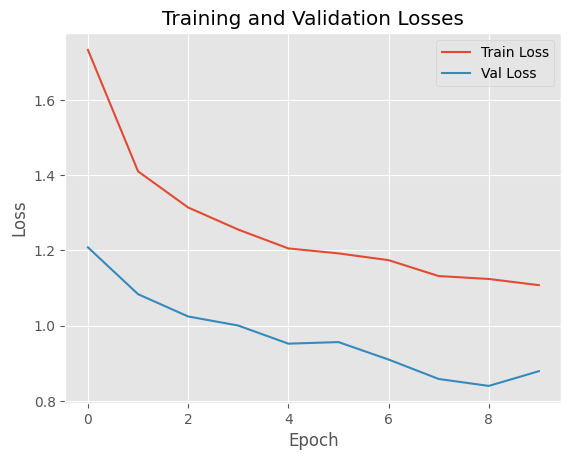

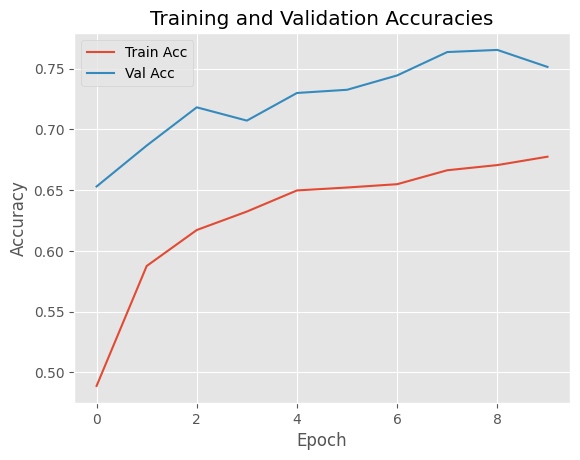

In [56]:
# Plotting training and validation losses
plt.style.use("ggplot")
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plotting training and validation accuracies
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

In [58]:
# Testing loop
model.eval()
correct_test = 0
total_test = 0
test_loss = 0  # Initialize test loss
with torch.no_grad():
    for inputs, labels in testDataLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()  # Accumulate test loss
        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

# Compute test accuracy
test_accuracy = correct_test / total_test
test_accuracies.append(test_accuracy)

print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Loss: {test_loss:.4f}')  

Test Accuracy: 0.74
Test Loss: 41.9177


**Comment:   
With pretrained 'VGG16' model, I got the test accuracy of upto 75%.**

# Model 3

In [32]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.to(device, non_blocking=True)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer for the new classification task
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Change the output layer according to the number of classes

# Move the model to GPU if available
model = model.to(device, non_blocking=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(10):  # You can increase the number of epochs as needed
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(trainDataLoader, desc=f'Epoch {epoch+1}/{10} - Train'):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=None)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainDataLoader)
    train_accuracy = correct / total
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(valDataLoader, desc=f'Epoch {epoch+1}/{10} - Validation'):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(valDataLoader)
    val_accuracy = correct / total
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    print(f'Epoch {epoch+1}/{10}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 15.61it/s]


Epoch 1/10, Train Loss: 1.6137, Train Acc: 0.5444, Val Loss: 1.0928, Val Acc: 0.6928


Epoch 2/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 15.45it/s]


Epoch 2/10, Train Loss: 0.9291, Train Acc: 0.7581, Val Loss: 0.8717, Val Acc: 0.7707


Epoch 3/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 15.71it/s]


Epoch 3/10, Train Loss: 0.7699, Train Acc: 0.7992, Val Loss: 0.7940, Val Acc: 0.7860


Epoch 4/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 15.58it/s]


Epoch 4/10, Train Loss: 0.7046, Train Acc: 0.8087, Val Loss: 0.7828, Val Acc: 0.7917


Epoch 5/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 15.70it/s]


Epoch 5/10, Train Loss: 0.6587, Train Acc: 0.8263, Val Loss: 0.7554, Val Acc: 0.7873


Epoch 6/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 15.89it/s]


Epoch 6/10, Train Loss: 0.6115, Train Acc: 0.8372, Val Loss: 0.6977, Val Acc: 0.8114


Epoch 7/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 15.73it/s]


Epoch 7/10, Train Loss: 0.5770, Train Acc: 0.8463, Val Loss: 0.6830, Val Acc: 0.8179


Epoch 8/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 16.37it/s]


Epoch 8/10, Train Loss: 0.5532, Train Acc: 0.8507, Val Loss: 0.6713, Val Acc: 0.8223


Epoch 9/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 16.16it/s]


Epoch 9/10, Train Loss: 0.5371, Train Acc: 0.8567, Val Loss: 0.6669, Val Acc: 0.8284


Epoch 10/10 - Validation: 100%|██████████| 36/36 [00:02<00:00, 15.84it/s]

Epoch 10/10, Train Loss: 0.5211, Train Acc: 0.8578, Val Loss: 0.6549, Val Acc: 0.8223


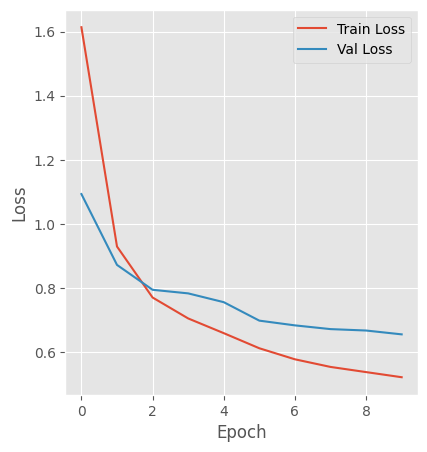

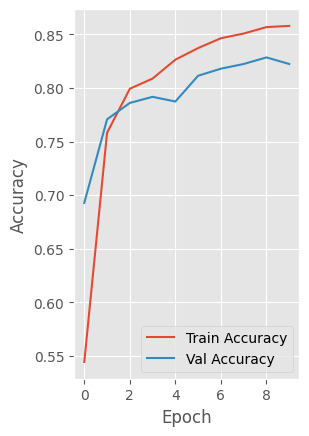

In [34]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
# Test
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(testDataLoader, desc='Test'):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test: 100%|██████████| 45/45 [00:02<00:00, 17.01it/s]

Test Accuracy: 0.8229


**Comment:   
With pretrained model 'ResNet18', I got test accuracy of upto 82%.**